The first training has not been too good. We will try out the following:

- Train purely on reconstruction loss
- Different weight init using Uniform Xavier, and bias init using zeros
- No final activation function, i.e. identity
- PCA on the inputs (maybe?)

In [21]:
%load_ext autoreload
%autoreload 2

# Define autroreload so that it doesn't cause pain in the ass when we change the functions and run this notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Imports

import pandas as pd
import numpy as np

# Define the relative paths, append it to the system path
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parents[2] # Gets the folder: Unconventional_Unmixing_Methods\NeuralNet
sys.path.append(str(project_root))

# Import the models and shi
from defs.helper_functions.training_functions import *
from defs.helper_functions.loss_functions import *
from defs.helper_functions.plot_functions import *

# Time, to precisely, time
import time

In [23]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")  # Force CPU for testing purposes
print(f"Using device: {device}")

Using device: cuda


In [24]:
# Basics of the dataset

master_root = Path.cwd().resolve().parents[7] # Gets the folder: UTAT on Ege's computer, which has Github and Data, use this to import the data
sys.path.append(str(master_root))

data_handle = rf'{master_root}\Data\General_Data\simpler_data_rwc.csv'

cfg_dataset = {
    'abundance_idx_range': [0,2], # -1 from original since we have spectra col
    'value_idx_range': [55,135], # -2 from original since we have use and spectra col
    'identity_idx_range': [3,3] # -1 from original since we have spectra col, use RWC as identity for now, since we do not have pure idx col
}

df = pd.read_csv(data_handle)
df = df.iloc[:-3] # Drop last 3 rows since we need divisible fold number to the rows
df = df.drop(columns=['Spectra', 'use']) # Drop these two since we will convert to a tensor
data_np = df.values.astype('float32')
data_tensor = torch.from_numpy(data_np)

In [28]:
# Cfgs for the network, optimizer, training

# Network cfg:

cfg_model = {
    'model_type': 'MLP',
    'input_dim': 81,
    'output_dim': 3,
    'hidden_layers': [128,256,256,128,64,16],
    'activation_list': ['Sigmoid', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'Sigmoid', 'Identity']
}

cfg_optim = {
    'algo': 'adamw',
    'lr': 1e-4
}

cfg_train = {
    'fold': 10,
    'batch_size': 1,
    'loss': 'recons'
}


In [29]:
cfg_loss = {
    'lambdas_ab': torch.tensor([15, 15, 15]), # Changed the losses to be uniform for the abundances
    'lambda_sum': 0.1,
    'lambda_bounds': 0.08
}

loss = ClassWisePhysical(cfg_loss= cfg_loss, device= device)

In [31]:
# Show the model

from torchviz import make_dot

# Create and move inputs to device
show_tensor = torch.randn(5, cfg_model['input_dim']).to(device)
model = initialize_model(cfg_model= cfg_model, device= device)
# Forward pass
output = model(show_tensor)

make_dot(output, params=dict(model.named_parameters())).render("model_graph", format="png")

'model_graph.png'

In [30]:
folds_dict = train_k_fold(cfg_train= cfg_train, cfg_dataset= cfg_dataset, cfg_model= cfg_model, cfg_optim= cfg_optim, dataset= data_tensor, device= device, loss= loss)

RuntimeError: grad can be implicitly created only for scalar outputs

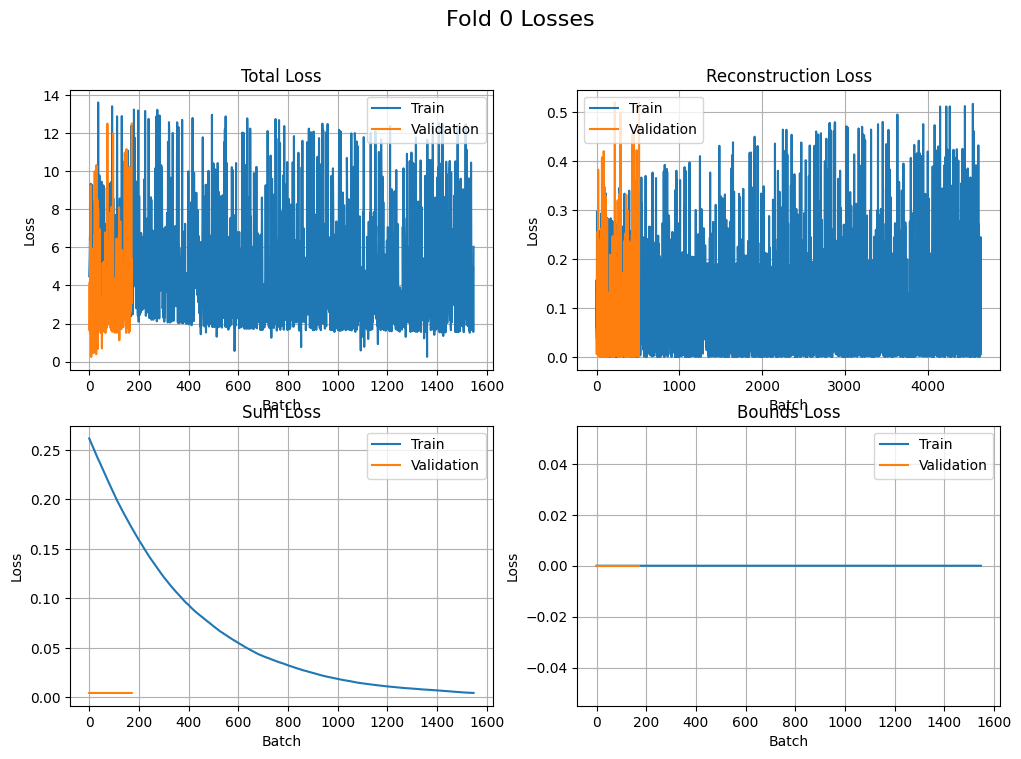

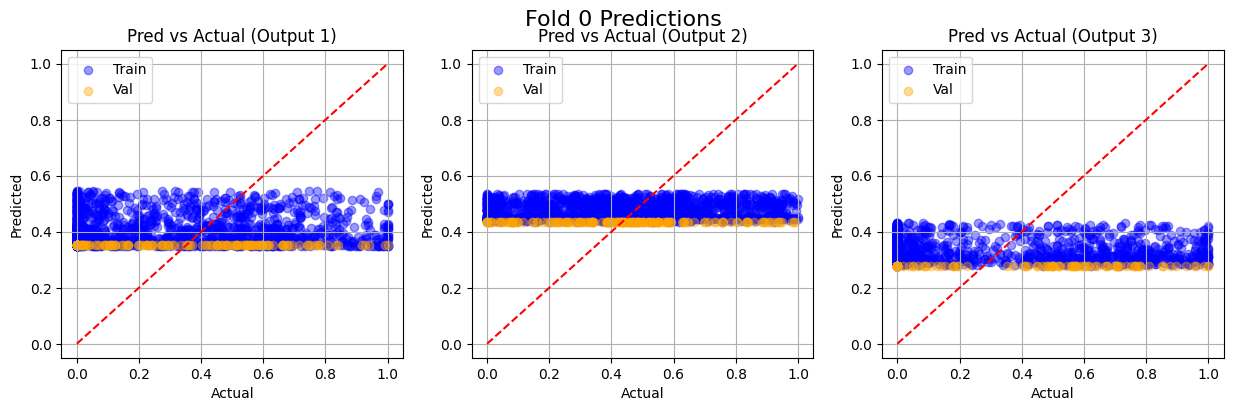

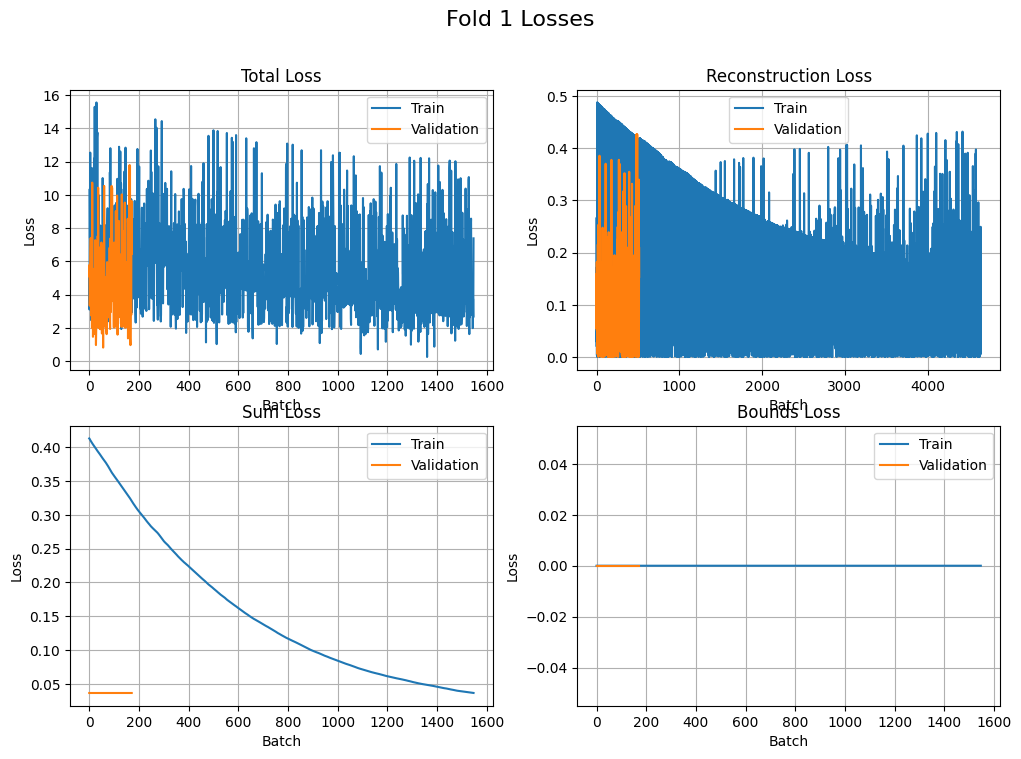

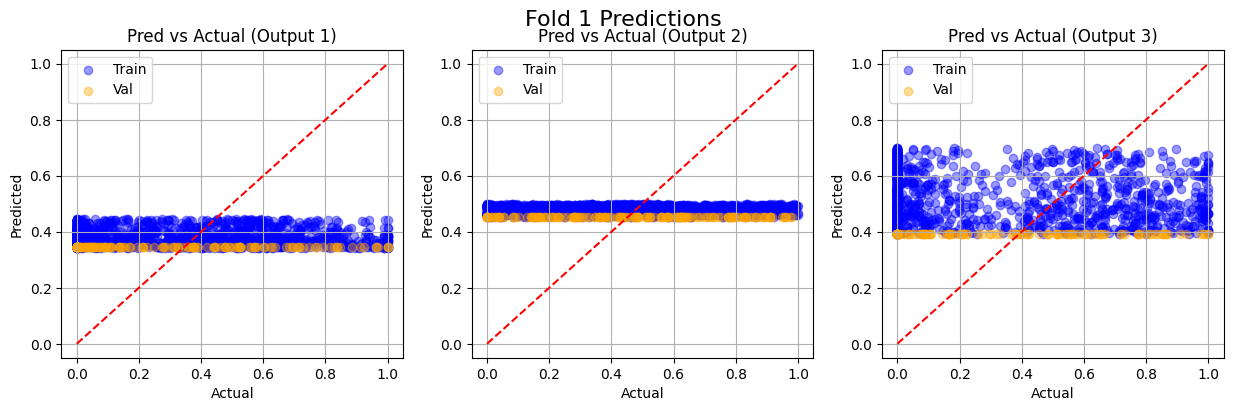

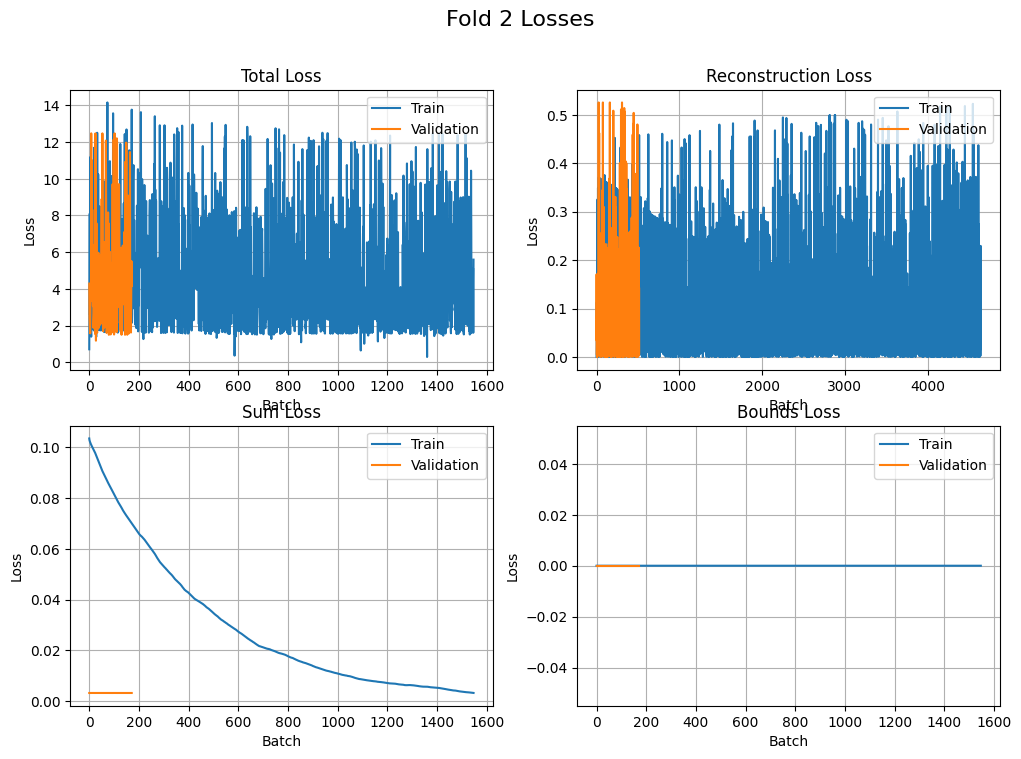

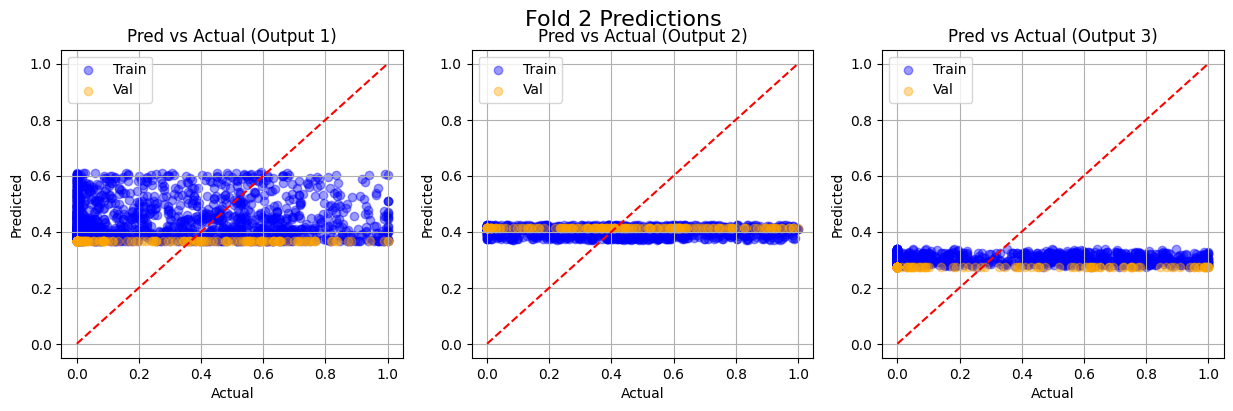

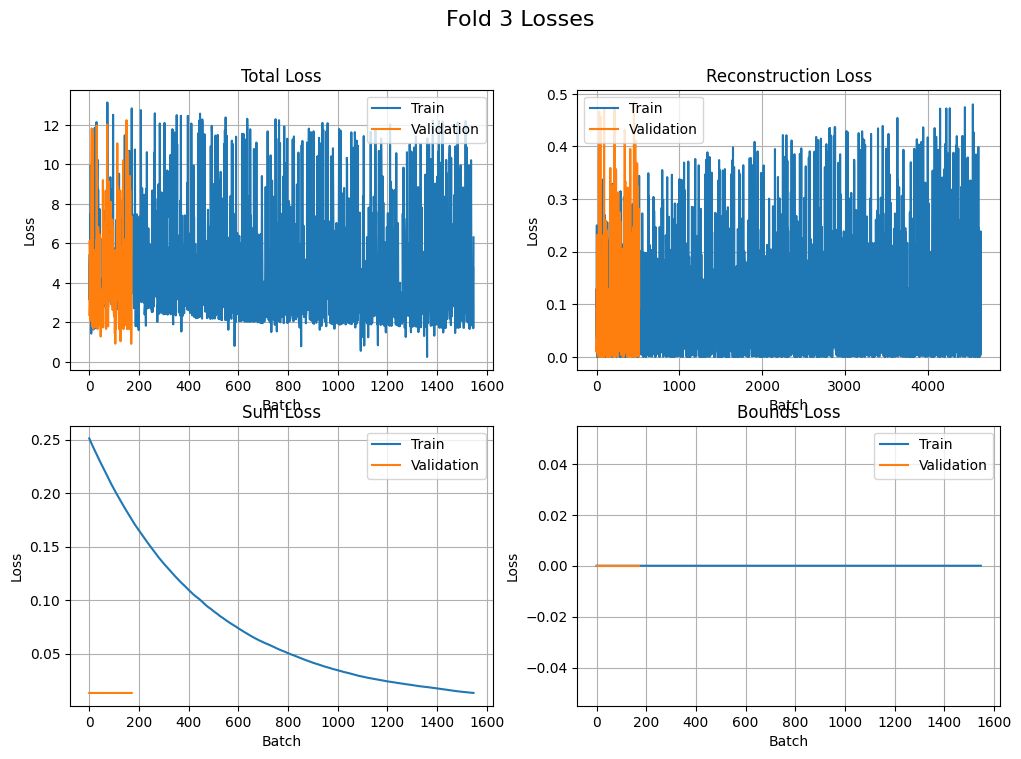

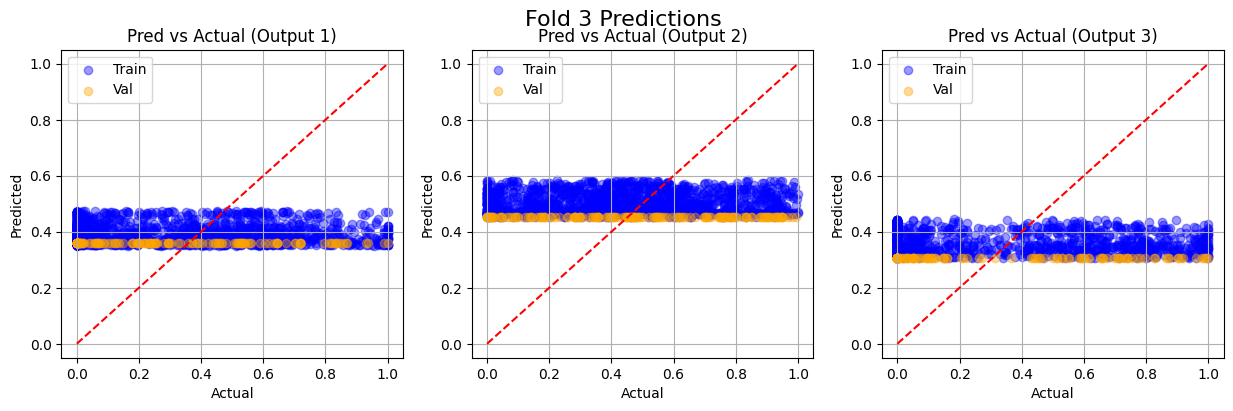

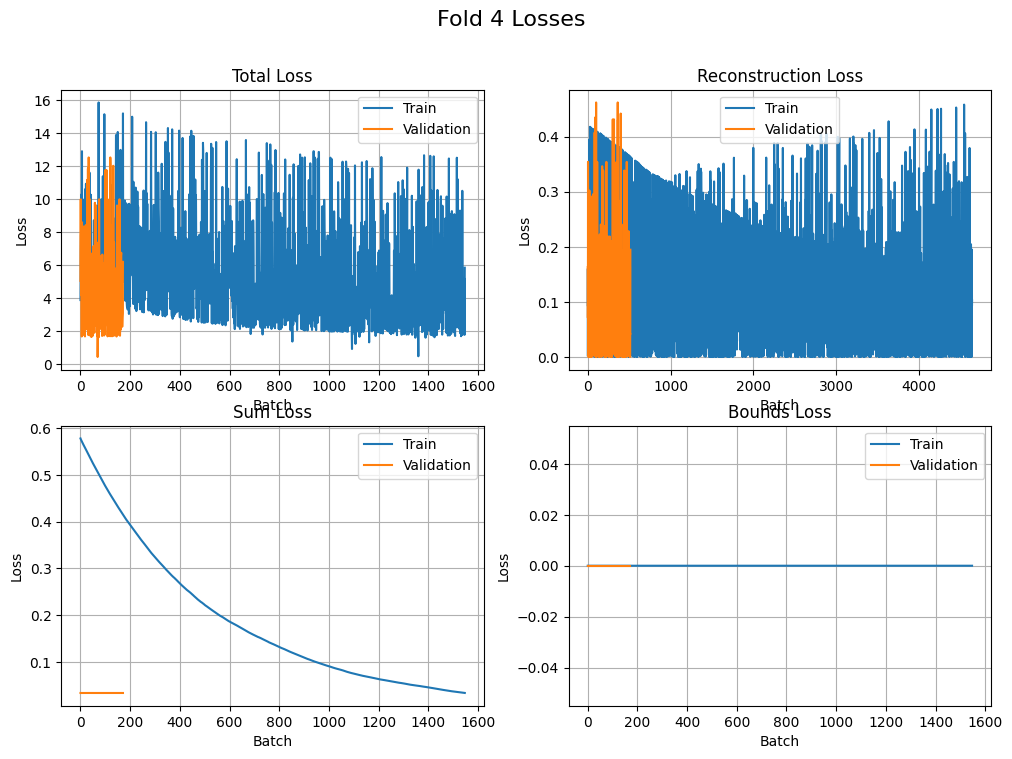

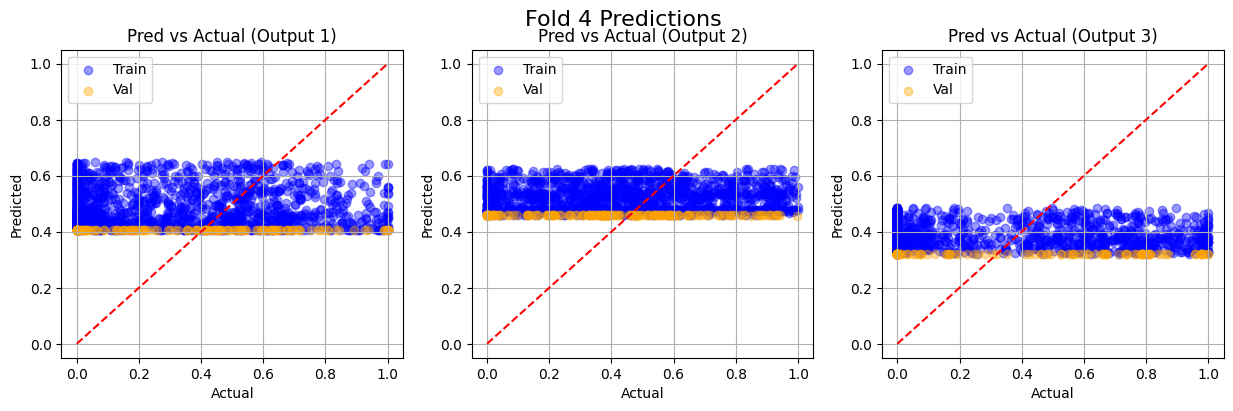

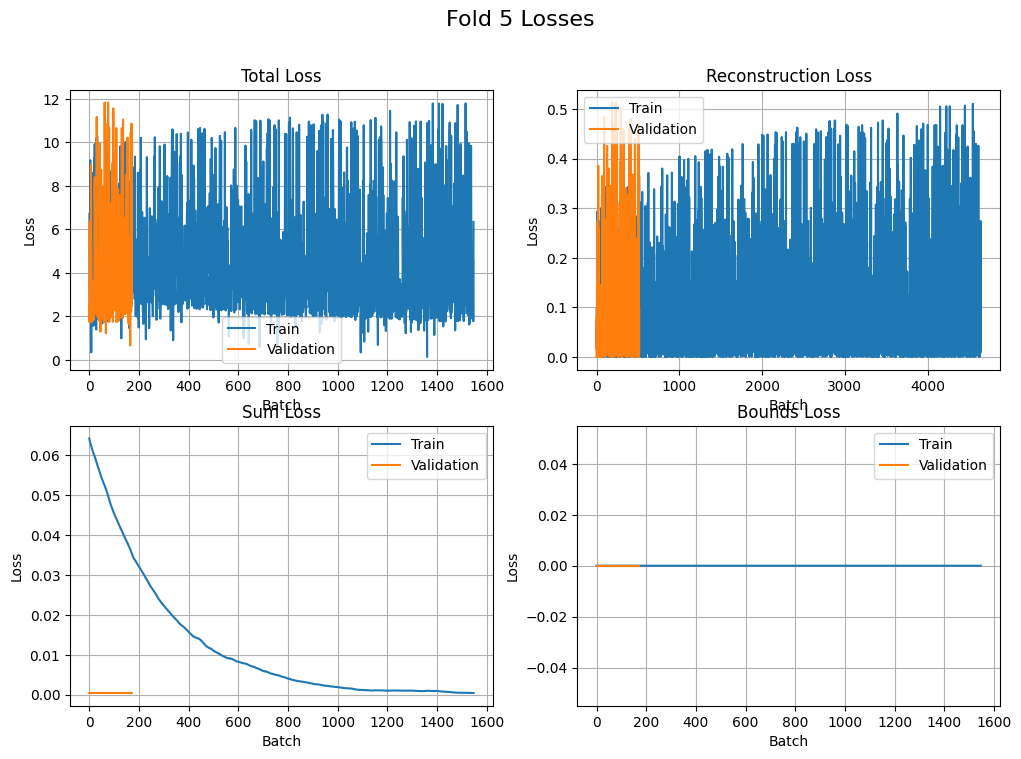

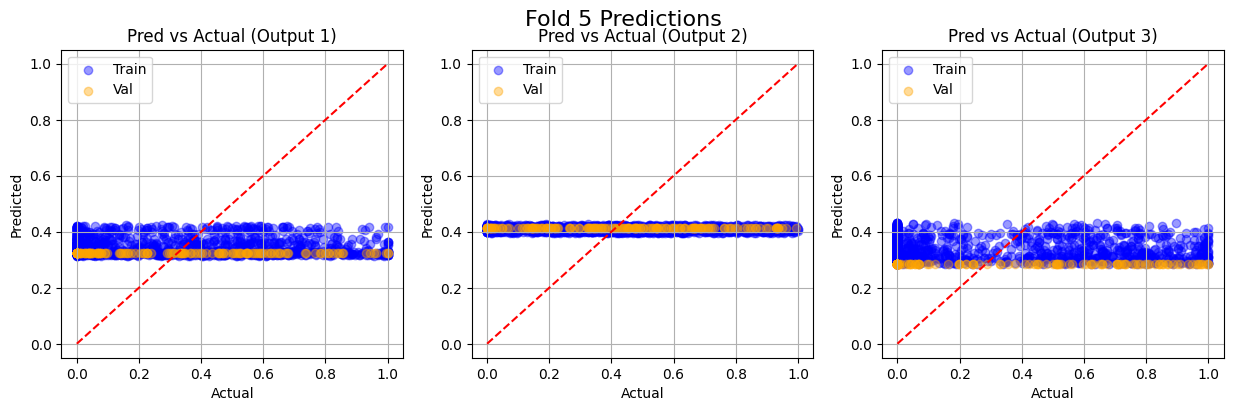

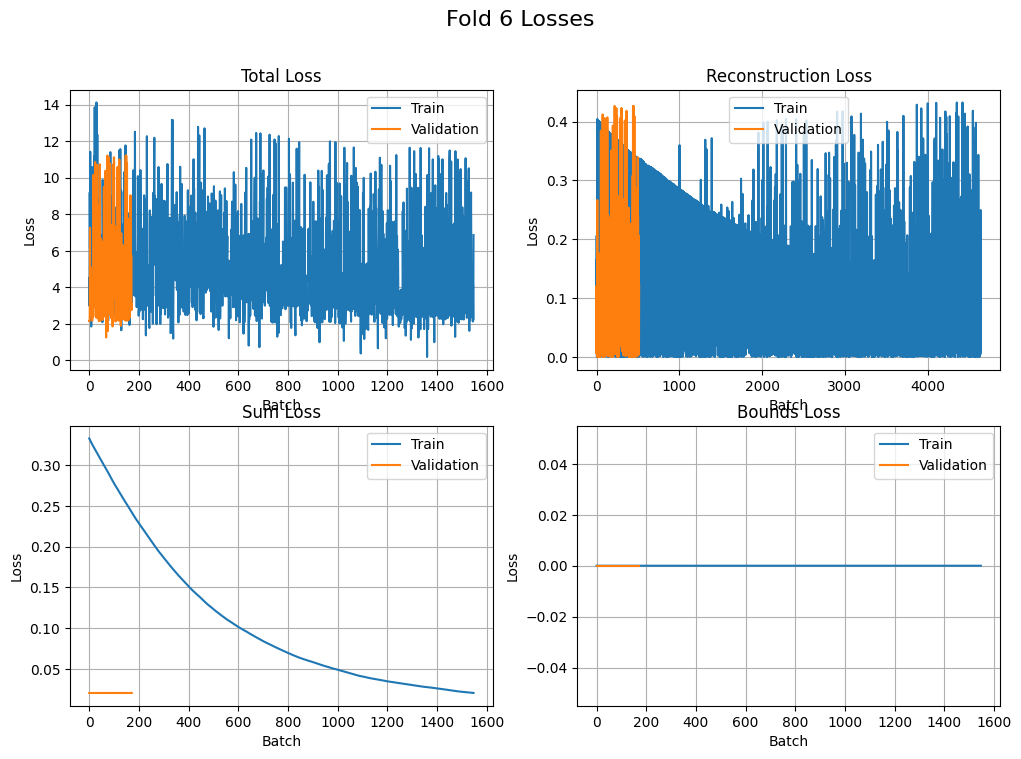

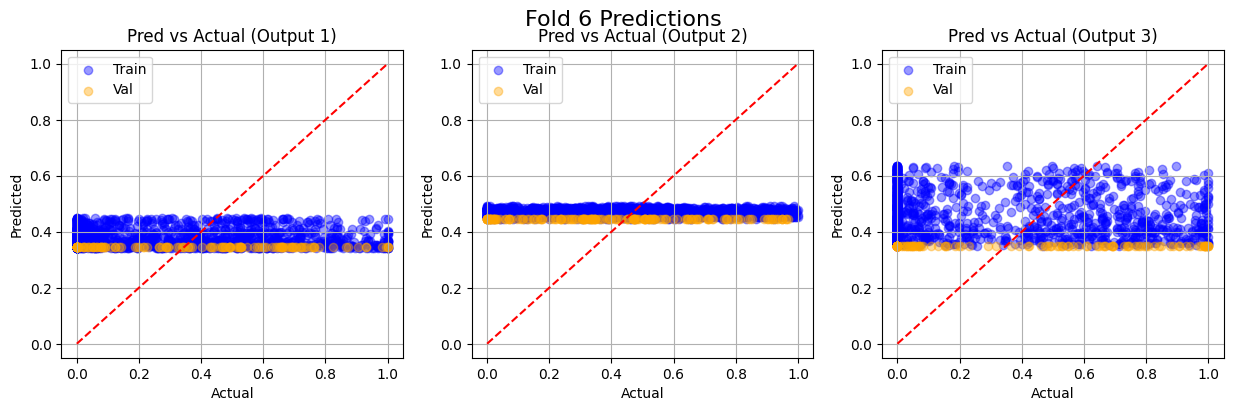

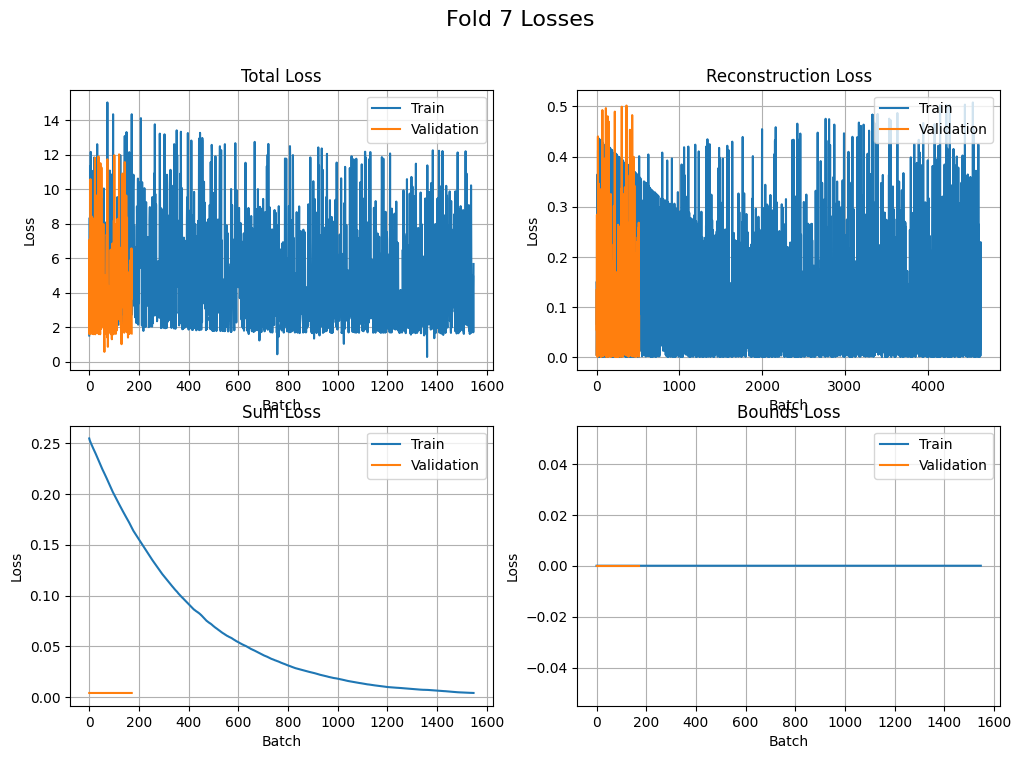

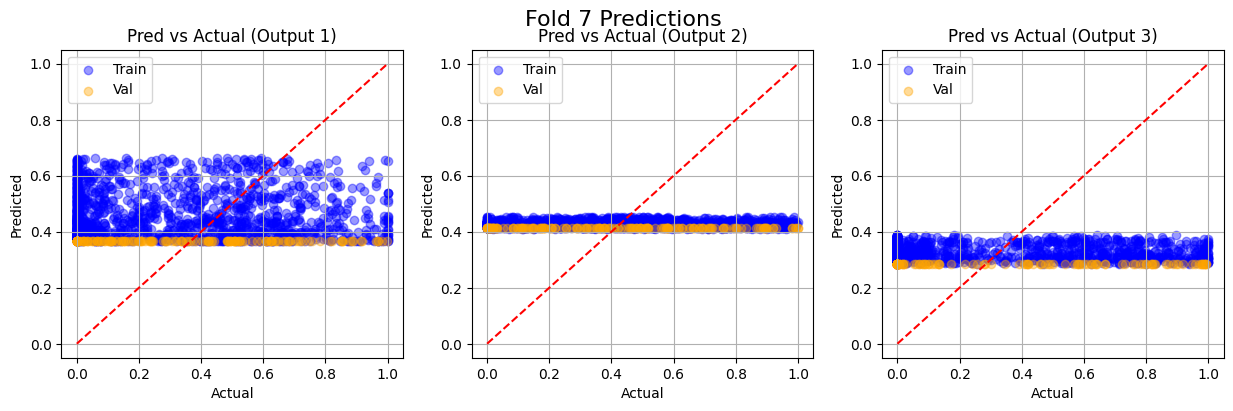

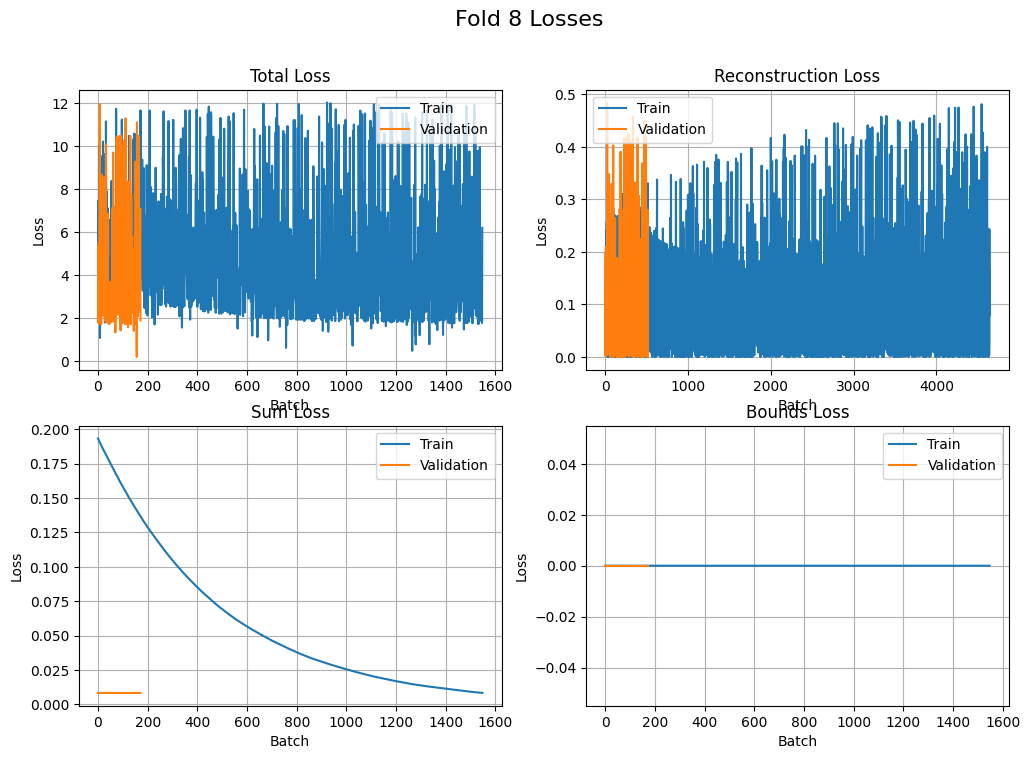

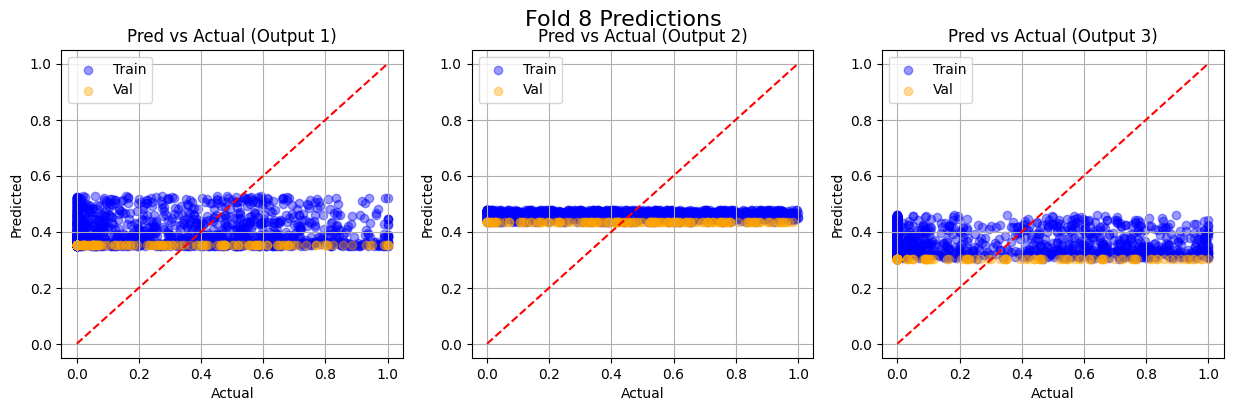

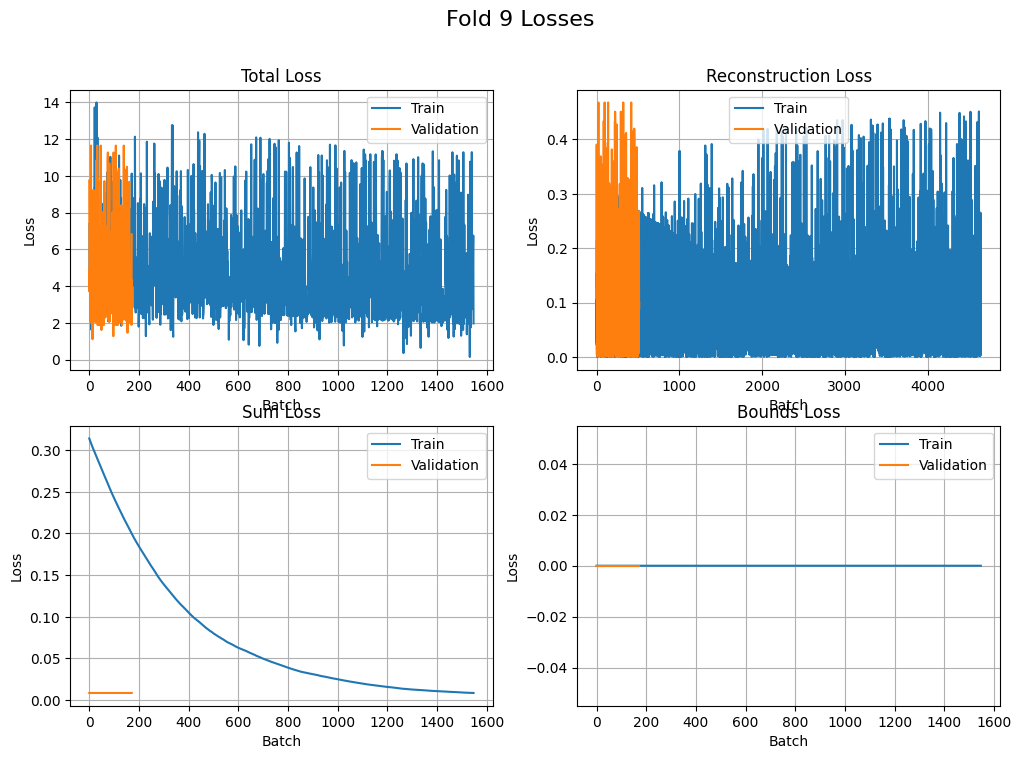

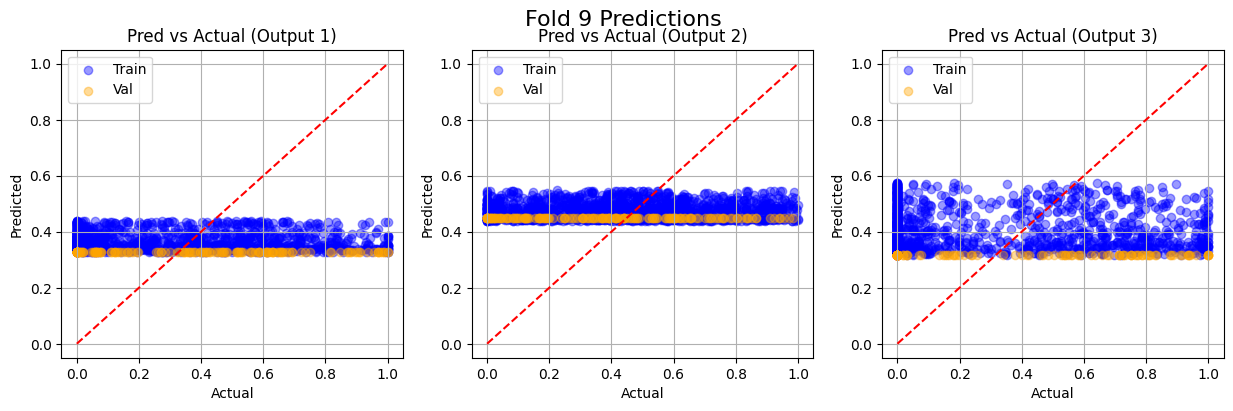

In [ ]:
for i in range(cfg_train['fold']):
    plot_fold_from_master(folds_dict, fold_idx=i)